# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №1. Image Classification. </center>

В данной лабораторной работе вам предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
pic = plt.imread('images/train/a/a_00002.jpg')
print(pic.shape)

(28, 28, 3)


In [3]:
pic = np.transpose(pic, axes=(1, 0, 2))

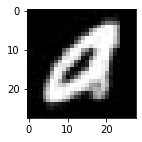

In [4]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

In [5]:
#torch.tensor(pic)

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

## Основные задания

импортнем все необходимое и создадим датасет с необходимыми преобразованиями

In [6]:
import os
import time
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader

In [7]:
def get_data_and_targets_lst(path):
    data=[]
    targets=[]
    for root, currentDirectory, files in os.walk(path):
        for file in files:
            pic = plt.imread(os.path.join(root, file))
            pic = torch.tensor(np.transpose(pic, axes=(1, 0, 2)))
            pic = torch.div(pic, 255)
            target = ord(file[0]) - ord('a')
            data.append(pic)
            targets.append(target)
    return data,targets

In [8]:
class MyDataset(torch.utils.data.Dataset): 
    
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        #return {'sample': self.x[idx], 'target': self.y[idx]}
        return self.x[idx],self.y[idx]

In [9]:
X,y = get_data_and_targets_lst("images/train")

Да, я знаю про ImageFolder только узнал про него под конец сдачи лабы и не успел заиспользовать. Буду юзать в следующих лабах.

In [10]:
X[60000].dtype

torch.float32

15


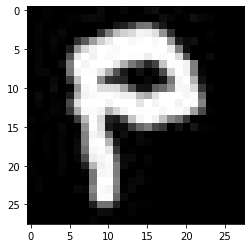

In [11]:
plt.imshow(X[60000])
print(y[60000])

In [12]:
len(y)

65000

разобьем трейн выборку на трейн и тест. Да, здесь получается небольшая тавтология

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [14]:
len(X_test), len(y_test)

(13000, 13000)

In [15]:
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
#train_dataset.__getitem__(40000)

In [16]:
batch_size=64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
for batch, (X, y) in enumerate(train_dataloader):
    print(batch)
    print(y)
    print("Shape of X [N, C, H, W]: ", X.shape)
    #NHWC now
    print("Shape of y: ", y.shape, y.dtype)
    break

0
tensor([15, 18, 24, 13, 15, 14,  1, 17, 18, 12, 15,  7, 22,  5, 17, 18, 24, 15,
        19, 13, 24,  9, 10, 17,  0, 14, 10, 18,  7, 10, 20, 20,  3,  6,  5, 23,
        16,  2, 16,  9,  2,  9,  5, 11, 17,  9, 22, 10,  9, 16, 11, 22,  0,  6,
         9,  8, 10, 10, 16,  9, 11,  1, 13, 20])
Shape of X [N, C, H, W]:  torch.Size([64, 28, 28, 3])
Shape of y:  torch.Size([64]) torch.int64


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


определяем, необходимые для цикла обучения, функции

In [18]:
def train(dataloader, model, loss_fn, optimizer, to_NCHW = False):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        if to_NCHW:
            X = X.permute(0, 3, 1, 2)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        #print(pred.shape)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [19]:
def test(dataloader, model, loss_fn, to_NCHW = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            if to_NCHW:
                X = X.permute(0, 3, 1, 2)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            #print(pred.shape)
            #print(loss_fn(pred, y).item())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [20]:
def get_model_accuracy(dataloader, model, to_NCHW = False):
    size = len(dataloader.dataset)
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            if to_NCHW:
                X = X.permute(0, 3, 1, 2)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return correct / size       

In [21]:
def get_all_model_predictions(dataloader, model):
    size = len(dataloader.dataset)
    correct = 0
    predictions = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            predictions.extend(pred.argmax(1))
#             if len(pred.argmax(1))>1:
#                 print(pred.argmax(1))
    return list(map(lambda x : x.item(), predictions)) 

In [22]:
def learning_cycle(epochs, model, loss_fn, optimizer, to_NCHW = False):
    for t in range(epochs):
        print(f"\nEpoch {t+1}\n-------------------------------")
        starttm = time.time()
        train(train_dataloader, model, loss_fn, optimizer, to_NCHW = to_NCHW)
        test(test_dataloader, model, loss_fn, to_NCHW = to_NCHW)
        endtm = time.time()
        print(f"Time: {(endtm - starttm):>0.3f}")
        #print("Done!")
    

# 1.1

попробуем создать первую модель

In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 26),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [24]:
model_lin3 = NeuralNetwork()

In [69]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_lin3.parameters(), lr=0.001)
learning_cycle(20, model_lin3, loss_fn, optimizer)


Epoch 1
-------------------------------
loss: 3.266612  [    0/52000]
loss: 3.256333  [ 6400/52000]
loss: 3.259235  [12800/52000]
loss: 3.254102  [19200/52000]
loss: 3.247063  [25600/52000]
loss: 3.242960  [32000/52000]
loss: 3.236003  [38400/52000]
loss: 3.242297  [44800/52000]
loss: 3.241168  [51200/52000]
Test Error: 
 Accuracy: 9.4%, Avg loss: 3.230580 

Time: 5.189

Epoch 2
-------------------------------
loss: 3.239915  [    0/52000]
loss: 3.229204  [ 6400/52000]
loss: 3.225756  [12800/52000]
loss: 3.219895  [19200/52000]
loss: 3.206959  [25600/52000]
loss: 3.216455  [32000/52000]
loss: 3.196655  [38400/52000]
loss: 3.203277  [44800/52000]
loss: 3.201773  [51200/52000]
Test Error: 
 Accuracy: 13.1%, Avg loss: 3.191783 

Time: 4.093

Epoch 3
-------------------------------
loss: 3.205072  [    0/52000]
loss: 3.191389  [ 6400/52000]
loss: 3.178328  [12800/52000]
loss: 3.170667  [19200/52000]
loss: 3.148660  [25600/52000]
loss: 3.177988  [32000/52000]
loss: 3.138831  [38400/52000]


учиться довольно медленно но +-стабильно

In [70]:
X_train[0].shape

torch.Size([28, 28, 3])

In [71]:
pred = model_lin3(X_train[30000].reshape([1,28,28,3]))

In [72]:
pred,y_train[30000]

(tensor([[ 4.0236,  3.4986, -3.8633,  2.0159, -0.5040,  2.0477,  2.8750,  3.9883,
          -1.9280, -0.9951, -1.0995, -1.9759, -4.1903,  0.3366, -0.7856,  1.9234,
           1.9889, -0.5599,  1.9155,  1.4569, -2.7263, -3.8149, -3.2514,  0.4331,
          -0.4101,  0.8618]], grad_fn=<AddmmBackward0>),
 0)

ради эксперимента создадим сеточку с двумя линейными слоями

In [26]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(28*28*3, 512),
            nn.Sigmoid(),
            nn.Linear(512, 26),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_sigmoid_stack(x)
        return logits

In [74]:
model_lin2 = NeuralNetwork2()

In [75]:
loss_fn = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(model_lin2.parameters(), lr=0.01)
learning_cycle(10, model_lin2, loss_fn, optimizer2)


Epoch 1
-------------------------------
loss: 3.315619  [    0/52000]
loss: 3.240739  [ 6400/52000]
loss: 3.162058  [12800/52000]
loss: 3.144874  [19200/52000]
loss: 3.084694  [25600/52000]
loss: 3.097035  [32000/52000]
loss: 2.998588  [38400/52000]
loss: 2.957730  [44800/52000]
loss: 2.949143  [51200/52000]
Test Error: 
 Accuracy: 35.7%, Avg loss: 2.907947 

Time: 3.678

Epoch 2
-------------------------------
loss: 2.927711  [    0/52000]
loss: 2.876177  [ 6400/52000]
loss: 2.735786  [12800/52000]
loss: 2.688974  [19200/52000]
loss: 2.562118  [25600/52000]
loss: 2.652033  [32000/52000]
loss: 2.424753  [38400/52000]
loss: 2.392004  [44800/52000]
loss: 2.449893  [51200/52000]
Test Error: 
 Accuracy: 47.1%, Avg loss: 2.356137 

Time: 3.654

Epoch 3
-------------------------------
loss: 2.382523  [    0/52000]
loss: 2.357459  [ 6400/52000]
loss: 2.153194  [12800/52000]
loss: 2.156525  [19200/52000]
loss: 1.994506  [25600/52000]
loss: 2.191278  [32000/52000]
loss: 1.889658  [38400/52000]

KeyboardInterrupt: 

судя по всему более простая модель только с двумя линейными слоями и учится значительно быстрее и выдает результаты далеко не хуже с точки зрения метрик

так же большое значение играет здесь learning rate 

прогоним на тестовой выборке

In [29]:
Xt,yt = get_data_and_targets_lst("images/test")

In [30]:
final_test_dataset = MyDataset(Xt, yt)
final_test_dataloader = DataLoader(final_test_dataset, batch_size=batch_size)

In [78]:
get_model_accuracy(final_test_dataloader, model_lin3)

0.625

In [79]:
get_model_accuracy(final_test_dataloader, model_lin2)

0.6367692307692308

In [179]:
#torch.save(model_lin2.state_dict(), "my_models/model90.pth")

In [181]:
# model_lin2 = NeuralNetwork2()
# model_lin2.load_state_dict(torch.load("my_models/model90.pth"))

<All keys matched successfully>

# 1.2

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

достанем одну из обученных мной линейных моделей

In [27]:
model_lin2 = NeuralNetwork2()
model_lin2.load_state_dict(torch.load("my_models/model90.pth"))

<All keys matched successfully>

In [28]:
predictions = get_all_model_predictions(final_test_dataloader, model_lin2)
len(predictions)

NameError: name 'final_test_dataloader' is not defined

In [82]:
print(13000/26)

500.0


In [83]:
cf_matrix = confusion_matrix(yt, predictions)

<AxesSubplot:>

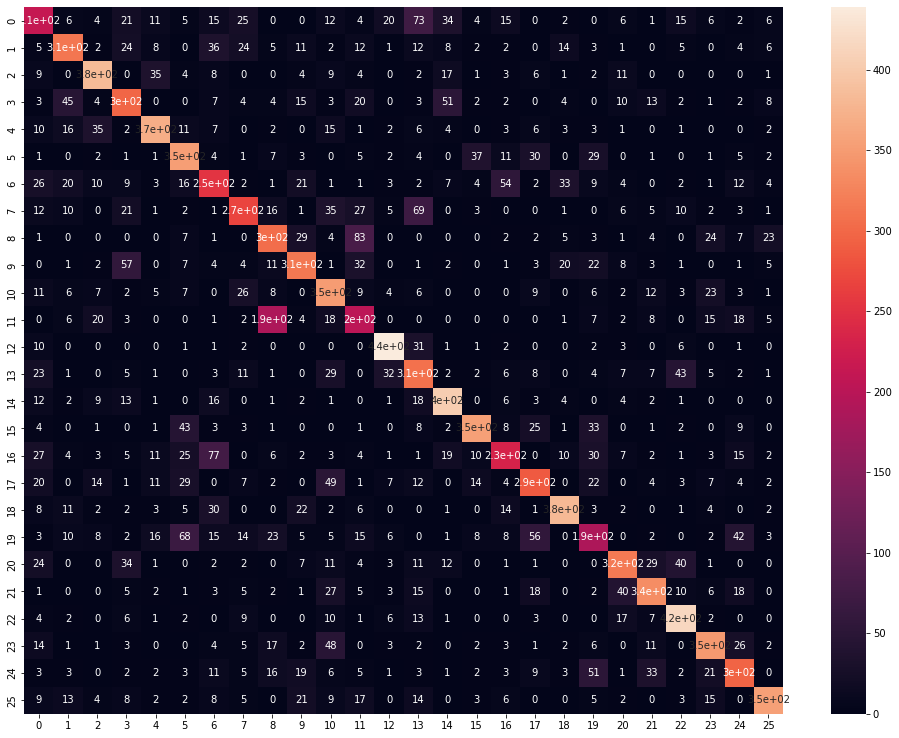

In [84]:
plt.figure(figsize=(17,13))
sns.heatmap(cf_matrix, annot=True)

<BarContainer object of 26 artists>

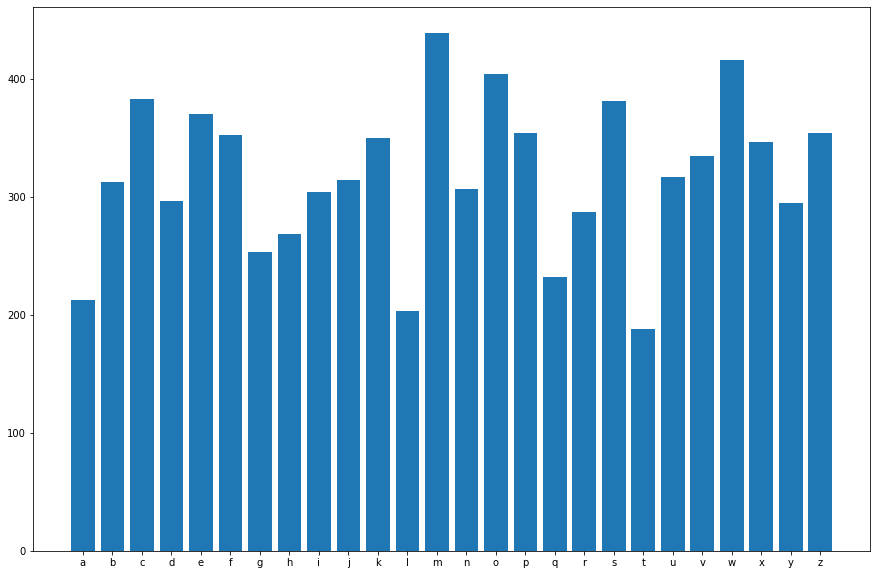

In [85]:
plt.figure(figsize=(15,10))
letters_stat = [cf_matrix[i][i] for i in range(26)]
plt.bar([chr(i+97) for i in range(26)], letters_stat)

буквы с наибольшей и наименьшей статистикой угадывания

In [86]:
chr(np.array(letters_stat).argmax() + 97), max(letters_stat)/500

('m', 0.878)

In [87]:
chr(np.array(letters_stat).argmin() + 97), min(letters_stat)/500

('t', 0.376)

если прогонять на самой лучшей модели - то лучше всего угадывается "o" хуже всего - "i"

предположительно, потому что у О очень простая структура (просто кружок) и что гораздо более важное - заглавная и строчная версия буквы никак не отличаются, чего не скажешь о "i"  или, например об "q"

# 1.3

In [88]:
def get_confusing_letters(cf_matrix, amount=10):
    matrix = cf_matrix.copy()
    for i in range(26):
        matrix[i][i] = 0
    confusion = []
    for i in range(26):
        for j in range(26):
            if len(confusion)<amount:
                confusion.append((matrix[i][j],chr(i+97),chr(j+97)))
            elif min(confusion, key=lambda el: el[0])[0] < matrix[i][j]:
                confusion = sorted(confusion, key=lambda el: el[0])
                confusion[0] = (matrix[i][j],chr(i+97),chr(j+97))
    return sorted(confusion, key=lambda el: el[0])

In [89]:
get_confusing_letters(cf_matrix, 20)

[(37, 'f', 'p'),
 (40, 'v', 'u'),
 (40, 'u', 'w'),
 (42, 't', 'y'),
 (43, 'p', 'f'),
 (43, 'n', 'w'),
 (45, 'd', 'b'),
 (48, 'x', 'k'),
 (49, 'r', 'k'),
 (51, 'y', 't'),
 (51, 'd', 'o'),
 (54, 'g', 'q'),
 (56, 't', 'r'),
 (57, 'j', 'd'),
 (68, 't', 'f'),
 (69, 'h', 'n'),
 (73, 'a', 'n'),
 (77, 'q', 'g'),
 (83, 'i', 'l'),
 (187, 'l', 'i')]

# 1.4 

In [90]:
sind = ord("s") - 97
cf_matrix[sind][sind]/500

0.762

In [91]:
sind

18

судя по confusion_matrix чаще всего модель путает букву "s" с буквами под номерами 6 и 9

In [92]:
chr(97+6), chr(97+9)

('g', 'j')

# 2

In [93]:
conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 18, 5)

In [94]:
for batch, (X, y) in enumerate(train_dataloader):
    X = X.permute(0, 3, 1, 2)
    print(X.shape)
    X = conv1(X)
    print(X.shape)
    X = pool(X)
    print(X.shape)
    X = conv2(X)
    print(X.shape)
    X = pool(X)
    print(X.shape)
    break

torch.Size([64, 3, 28, 28])
torch.Size([64, 6, 24, 24])
torch.Size([64, 6, 12, 12])
torch.Size([64, 18, 8, 8])
torch.Size([64, 18, 4, 4])


In [95]:
class Conv2NeuralNetwork(nn.Module):
    def __init__(self):
        super(Conv2NeuralNetwork, self).__init__()
        self.convolution_relu_stack = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(6, 18, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(18*4*4,120),
            nn.ReLU(),
            nn.Linear(120,26)
        )
    def forward(self, x):
        x = self.convolution_relu_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [96]:
for batch, (X, y) in enumerate(train_dataloader):
    c = Conv2NeuralNetwork()
    print(c(X.permute(0, 3, 1, 2)).shape)
    break

torch.Size([64, 26])


In [97]:
model_conv2 = Conv2NeuralNetwork()

In [98]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv2.parameters(), lr=0.001)
learning_cycle(20, model_conv2, loss_fn, optimizer, to_NCHW=True)


Epoch 1
-------------------------------
loss: 3.266120  [    0/52000]
loss: 3.258565  [ 6400/52000]
loss: 3.266794  [12800/52000]
loss: 3.261568  [19200/52000]
loss: 3.245223  [25600/52000]
loss: 3.261362  [32000/52000]
loss: 3.247818  [38400/52000]
loss: 3.244194  [44800/52000]
loss: 3.256661  [51200/52000]
Test Error: 
 Accuracy: 4.2%, Avg loss: 3.256540 

Time: 3.430

Epoch 2
-------------------------------
loss: 3.263640  [    0/52000]
loss: 3.257252  [ 6400/52000]
loss: 3.264859  [12800/52000]
loss: 3.259072  [19200/52000]
loss: 3.242941  [25600/52000]
loss: 3.259433  [32000/52000]
loss: 3.245409  [38400/52000]
loss: 3.241144  [44800/52000]
loss: 3.255289  [51200/52000]
Test Error: 
 Accuracy: 6.1%, Avg loss: 3.253584 

Time: 3.288

Epoch 3
-------------------------------
loss: 3.260544  [    0/52000]
loss: 3.255657  [ 6400/52000]
loss: 3.262324  [12800/52000]
loss: 3.255222  [19200/52000]
loss: 3.238937  [25600/52000]
loss: 3.256399  [32000/52000]
loss: 3.241636  [38400/52000]
l

модель учится лучше линейной, но по опыту сильно лучших результатов (более 92 процентов акьюраси она не достигнет)

когда я только начинал разбираться в лабе - я прогонял линейные модели по сотням эпох и вяснил, что при должном усердии они тоже могут дойти до 90% но на это уйдет значительно больше эпох. Побороть отметку в 91.2 или около того мне пока не удалось

In [100]:
conv1 = nn.Conv2d(3, 8, 3)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(8, 16, 4)
conv3 = nn.Conv2d(16, 18, 2)

In [101]:
for batch, (X, y) in enumerate(train_dataloader):
    X = X.permute(0, 3, 1, 2)
    print(X.shape)
    X = conv1(X)
    print(X.shape)
    X = pool(X)
    print(X.shape)
    X = conv2(X)
    print(X.shape)
    X = pool(X)
    print(X.shape)
    X = conv3(X)
    print(X.shape)
    X = pool(X)
    print(X.shape)
    break

torch.Size([64, 3, 28, 28])
torch.Size([64, 8, 26, 26])
torch.Size([64, 8, 13, 13])
torch.Size([64, 16, 10, 10])
torch.Size([64, 16, 5, 5])
torch.Size([64, 18, 4, 4])
torch.Size([64, 18, 2, 2])


In [64]:
class Conv3NeuralNetwork(nn.Module):
    def __init__(self):
        super(Conv3NeuralNetwork, self).__init__()
        self.convolution_relu_stack = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 4),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 18, 2),
            nn.MaxPool2d(2, 2),
        )
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(18*2*2,64),
            nn.ReLU(),
            nn.Linear(64,48),
            nn.ReLU(),
            nn.Linear(48,26),
        )
    def forward(self, x):
        x = self.convolution_relu_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [110]:
model_conv3 = Conv3NeuralNetwork()

In [111]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv3.parameters(), lr=0.01)
learning_cycle(20, model_conv3, loss_fn, optimizer, to_NCHW=True)


Epoch 1
-------------------------------
loss: 3.261536  [    0/52000]
loss: 3.266057  [ 6400/52000]
loss: 3.275798  [12800/52000]
loss: 3.268349  [19200/52000]
loss: 3.249639  [25600/52000]
loss: 3.252008  [32000/52000]
loss: 3.248871  [38400/52000]
loss: 3.261035  [44800/52000]
loss: 3.262128  [51200/52000]
Test Error: 
 Accuracy: 6.1%, Avg loss: 3.250494 

Time: 3.592

Epoch 2
-------------------------------
loss: 3.254905  [    0/52000]
loss: 3.254326  [ 6400/52000]
loss: 3.255819  [12800/52000]
loss: 3.233713  [19200/52000]
loss: 3.221758  [25600/52000]
loss: 3.241464  [32000/52000]
loss: 3.201316  [38400/52000]
loss: 3.184546  [44800/52000]
loss: 3.136757  [51200/52000]
Test Error: 
 Accuracy: 12.4%, Avg loss: 3.110081 

Time: 3.606


In [158]:
get_model_accuracy(final_test_dataloader, model_conv3, to_NCHW=True)

0.9140769230769231

In [159]:
#torch.save(model_conv3.state_dict(), "my_models/model91conv3.pth")

In [122]:
class Conv1NeuralNetwork(nn.Module):
    def __init__(self):
        super(Conv1NeuralNetwork, self).__init__()
        self.convolution_relu_stack = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(24*24*6,1024),
            nn.ReLU(),
            nn.Linear(1024,26)
        )
    def forward(self, x):
        x = self.convolution_relu_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

на этом этапе тренировать сетку с одной сверткой уже не интересно, потому что очевидно, что результаты она покажет ощутимо хуже

In [33]:
class Conv3NeuralNetworkBN(nn.Module):
    def __init__(self):
        super(Conv3NeuralNetworkBN, self).__init__()
        self.convolution_relu_stack = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 4),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 18, 2),
            nn.MaxPool2d(2, 2),
        )
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(18*2*2,64),
            nn.ReLU(),
            nn.Linear(64,48),
            nn.ReLU(),
            nn.Linear(48,26),
        )
    def forward(self, x):
        x = self.convolution_relu_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Ни одну сетку у меня не получилось доучить более чем на 91 процента accuracy

следующим этапом будут эксперименты с размером батча

In [38]:
class Conv3NeuralNetworkGN(nn.Module):
    def __init__(self):
        super(Conv3NeuralNetworkGN, self).__init__()
        self.convolution_relu_stack = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.MaxPool2d(2, 2),
            nn.GroupNorm(4,8),
            nn.Conv2d(8, 16, 4),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 18, 2),
            nn.MaxPool2d(2, 2),
        )
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(18*2*2,64),
            nn.ReLU(),
            nn.Linear(64,48),
            nn.ReLU(),
            nn.Linear(48,26),
        )
    def forward(self, x):
        x = self.convolution_relu_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [39]:
model_conv3 = Conv3NeuralNetworkGN()

In [40]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv3.parameters(), lr=0.01)
learning_cycle(100, model_conv3, loss_fn, optimizer, to_NCHW=True)


Epoch 1
-------------------------------
loss: 3.258589  [    0/52000]
loss: 3.261430  [25800/52000]
loss: 3.246637  [51600/52000]
Test Error: 
 Accuracy: 4.6%, Avg loss: 3.255873
Time: 3.623

Epoch 2
-------------------------------
loss: 3.252535  [    0/52000]
loss: 3.252947  [25800/52000]
loss: 3.236967  [51600/52000]
Test Error: 
 Accuracy: 7.5%, Avg loss: 3.246127
Time: 3.398

Epoch 3
-------------------------------
loss: 3.244915  [    0/52000]
loss: 3.238783  [25800/52000]
loss: 3.215874  [51600/52000]


KeyboardInterrupt: 

In [41]:
batch_size=258
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [42]:
model_conv3 = Conv3NeuralNetworkBN()

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv3.parameters(), lr=0.01)
learning_cycle(20, model_conv3, loss_fn, optimizer, to_NCHW=True)


Epoch 1
-------------------------------
loss: 3.268945  [    0/52000]
loss: 3.253118  [25800/52000]
loss: 3.244647  [51600/52000]
Test Error: 
 Accuracy: 4.4%, Avg loss: 3.245353
Time: 3.807

Epoch 2
-------------------------------
loss: 3.254236  [    0/52000]
loss: 3.234674  [25800/52000]
loss: 3.213822  [51600/52000]
Test Error: 
 Accuracy: 7.6%, Avg loss: 3.212752
Time: 3.304

Epoch 3
-------------------------------
loss: 3.224687  [    0/52000]
loss: 3.175315  [25800/52000]
loss: 3.057386  [51600/52000]
Test Error: 
 Accuracy: 11.0%, Avg loss: 3.053830
Time: 4.720

Epoch 4
-------------------------------
loss: 3.080420  [    0/52000]
loss: 2.813241  [25800/52000]
loss: 2.369036  [51600/52000]
Test Error: 
 Accuracy: 31.4%, Avg loss: 2.368050
Time: 3.598

Epoch 5
-------------------------------
loss: 2.437104  [    0/52000]
loss: 2.072988  [25800/52000]
loss: 1.676896  [51600/52000]
Test Error: 
 Accuracy: 47.6%, Avg loss: 1.739804
Time: 4.427

Epoch 6
----------------------------

KeyboardInterrupt: 

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv3.parameters(), lr=0.001)
learning_cycle(20, model_conv3, loss_fn, optimizer, to_NCHW=True)

Epoch 1
-------------------------------
loss: 0.257824  [    0/52000]
loss: 0.329321  [25800/52000]
loss: 0.313272  [51600/52000]
Test Error: 
 Accuracy: 89.4%, Avg loss: 0.321442 

Epoch 2
-------------------------------
loss: 0.262274  [    0/52000]
loss: 0.327841  [25800/52000]
loss: 0.312864  [51600/52000]
Test Error: 
 Accuracy: 89.4%, Avg loss: 0.320899 

Epoch 3
-------------------------------
loss: 0.262055  [    0/52000]
loss: 0.327272  [25800/52000]
loss: 0.312225  [51600/52000]
Test Error: 
 Accuracy: 89.4%, Avg loss: 0.320536 

Epoch 4
-------------------------------
loss: 0.261726  [    0/52000]
loss: 0.326914  [25800/52000]
loss: 0.311740  [51600/52000]
Test Error: 
 Accuracy: 89.4%, Avg loss: 0.320223 

Epoch 5
-------------------------------
loss: 0.261486  [    0/52000]
loss: 0.326612  [25800/52000]
loss: 0.311202  [51600/52000]
Test Error: 
 Accuracy: 89.4%, Avg loss: 0.319933 

Epoch 6
-------------------------------
loss: 0.261245  [    0/52000]
loss: 0.326288  [258

KeyboardInterrupt: 

# 3

здесь загрузим пару моделей из обученных мной и продемонстрируем результаты на тестовых данных

In [91]:
model90 = NeuralNetwork2()
model90.load_state_dict(torch.load("my_models/model90.pth"))

<All keys matched successfully>

In [92]:
get_model_accuracy(final_test_dataloader, model90)

0.9027692307692308

### Задание 1  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ. 
2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.  
Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.
3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.
4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву?     

### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.  
2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.    

### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

# B1

я написал все буквы черной ручкой на белом листочке, больше всего меня интересовали q и p

In [65]:
model90 = Conv3NeuralNetwork()
model90.load_state_dict(torch.load("my_models/model91conv3.pth"))

<All keys matched successfully>

In [66]:
model90n = NeuralNetwork2()
model90n.load_state_dict(torch.load("my_models/model90.pth"))

<All keys matched successfully>

In [67]:
mX,my = get_data_and_targets_lst("custom_images")

In [68]:
my

[16, 25, 0, 12, 15]

In [69]:
for el in mX:
    print(el.shape)

torch.Size([1080, 1012, 3])
torch.Size([958, 1080, 3])
torch.Size([1043, 1080, 3])
torch.Size([936, 1080, 3])
torch.Size([1034, 1080, 3])


In [70]:
import cv2

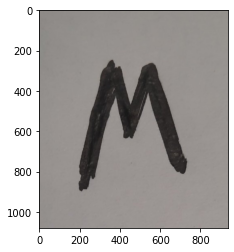

In [71]:
image = plt.imread('custom_images/m.jpg')
plt.imshow(image)

plt.show()

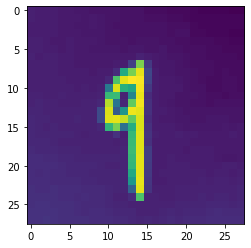

In [72]:
image = cv2.imread('custom_images/q.jpg')
#gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image = cv2.resize(image, (28,28), interpolation=cv2.INTER_AREA)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image= np.invert(image)
plt.imshow(image)
plt.show()

In [73]:
result = np.zeros([28, 28, 3])

In [74]:
for i in range(28):
    for j in range(28):
        result[i][j][0] = image[i][j]/255
        result[i][j][1] = image[i][j]/255
        result[i][j][2] = image[i][j]/255

In [75]:
result = torch.from_numpy(result)
result = result.float()
result.dtype

torch.float32

In [76]:
res_tens = model90(result.reshape([1,3,28,28]))

In [77]:
res_tens.argmax(1)

tensor([16])

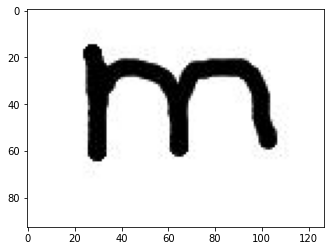

In [78]:
image = plt.imread('custom_images/0m.jpg')
plt.imshow(image)

plt.show()

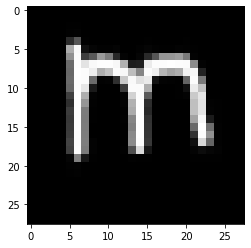

In [100]:
image = cv2.imread('custom_images/0m.jpg')

image = cv2.resize(image, (28,28), interpolation=cv2.INTER_AREA)
#image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image= np.invert(image)
plt.imshow(image)
plt.show()

In [106]:
image = torch.tensor(image)
image = torch.div(image, 255)

In [112]:
res_tens = model90(image.reshape([1,3,28,28]))
res_tens.argmax(1)

tensor([3])

In [111]:
ord("m") - 97

12

**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/vision/stable/models.html).

In [119]:
import torchvision.models as models

In [120]:
resnet = models.resnet18(pretrained=True)

In [121]:
get_model_accuracy(final_test_dataloader, resnet, to_NCHW=True)

0.0005384615384615384

In [118]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01)
learning_cycle(5, resnet, loss_fn, optimizer, to_NCHW=True)


Epoch 1
-------------------------------
loss: 0.231464  [    0/52000]


KeyboardInterrupt: 

In [122]:
resnet = models.resnet18(pretrained=False)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01)
learning_cycle(5, resnet, loss_fn, optimizer, to_NCHW=True)


Epoch 1
-------------------------------
loss: 7.061723  [    0/52000]
loss: 0.665672  [25800/52000]
loss: 0.403107  [51600/52000]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.463714
Time: 265.822

Epoch 2
-------------------------------
loss: 0.416906  [    0/52000]


In [ ]:
get_model_accuracy(final_test_dataloader, resnet, to_NCHW=True)

**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.